# Lab 1A

*Authors: Pablo Montes, Oscar Reula, Joaquin Pelle*

### Important 1: ###

This notebook is designed to be run in Julia.

### Important 2: ###

Rename the file as: 

`lastname_firstname_lab_1.ipynb`

**All generated code and the presentation must be included in this notebook.**

**The objectives of the first assignments are varied:**

1. Build some simple integrators and apply them to problems in 1 and 2 dimensions.
2. Study convergence and determine the method's Q factor.
3. Study the convergence region of the methods.
4. Check the approximation errors both qualitatively and quantitatively.
5. Get familiar with ODE integrator libraries.
6. Get familiar with handling and analyzing solutions in moderately complex cases.
7. Study the stiff case and IMEX methods.


**1)** The differential equation

$$
\frac{dy}{dt} = \lambda y
$$

has as its solution the function  
$$ y(t) = Ce^{\lambda t}, $$
where $C$ is a constant that depends on the initial condition.

We will solve it numerically using the Euler method,  
$$y(t+\Delta t) \approx y(t) + \Delta t \dfrac{dy}{dt}(t) = y(t) + \Delta t \lambda y(t)$$  
taking $\lambda = 2$ and initial condition $y(0) = 1$ over the time interval $[0,2]$.



**Implementation of the method:**

A simple way to implement the Euler method would be the following:


# Initial data
λ = 2
y0 = 1
# Number of time steps and dt
Tfin = 2.0
N = 201
dt = Tfin/(N-1)

# Vectors to store the solution
times = zeros(N)
y = zeros(N)
y[1] = y0
# Time evolution using the Euler method
for i in 2:N
    times[i] = dt*(i-1)      # Update the value of t
    y[i] = y[i-1] + dt*λ*y[i]  # Perform one Euler step
end

What we will do is split this procedure into a few small functions, so that in the future, if we want to change the numerical method or solve a different differential equation, we can do so directly. 


Our implementation of Euler's method is as follows:

In [8]:
# Functions to numerically solve equations of the form dy/dt = f(y, par, t)

function EulerStep(y, f, par, t, dt)
    """Euler method"""
    return y + dt * f(y, par, t)          # Euler method step
end

function myODEproblem(f, y0, interval, par)
    """Return f, y0, the time interval, and the function parameters as a tuple"""
    return (f, y0, interval, par)
end

function myODEsolver(Problem, Method; dt::Float64 = 0.01)
    # Solve the problem 'Problem' using the method 'Method' with time step dt
    f, y0, interval, par = Problem         # Specific data for the problem we're solving
    tini, tfin = interval                  # Initial and final times
    N = 1 + convert(Int64, (tfin - tini) / dt)  # Number of time steps
    y = Array{typeof(y0[1])}(undef, N, length(y0))  # Array to store y
    t = zeros(N)                           # Array to store t
    y[1,:] .= y0                           # Initial condition
    t[1] = tini
    for i in 2:N
        t[i] = tini + (i - 1) * dt
        y[i,:] .= Method(y[i-1,:], f, par, t[i-1], dt)   # Time step
    end
    return (t, y)
end


myODEsolver (generic function with 1 method)

In [9]:
# 1) Problem data:
# Define the right-hand side of the ODE
ExponentialGrowth(y, t, λ) = λ*(y)
# Initial data
λ = 1.0 
y0 = 1.0
# Time interval
T = (0.0, 4.0)
# Store the data in the variable "prob"
par = (λ)
prob = myODEproblem(ExponentialGrowth, y0, T, par)

(Main.ExponentialGrowth, 1.0, (0.0, 4.0), 1.0)

In [10]:
# Number of time steps
N = 101
# Solve the problem "prob" using the "EulerStep" method 
# with N steps (dt = (Tfin - Tini)/(N - 1))
dt = (T[2] - T[1]) / (N - 1)
t, y = myODEsolver(prob, EulerStep, dt = dt)

([0.0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36  …  3.64, 3.68, 3.72, 3.7600000000000002, 3.8000000000000003, 3.84, 3.88, 3.92, 3.96, 4.0], [1.0; 1.0; … ; 1608.7867053833593; 1863.6185195160833;;])

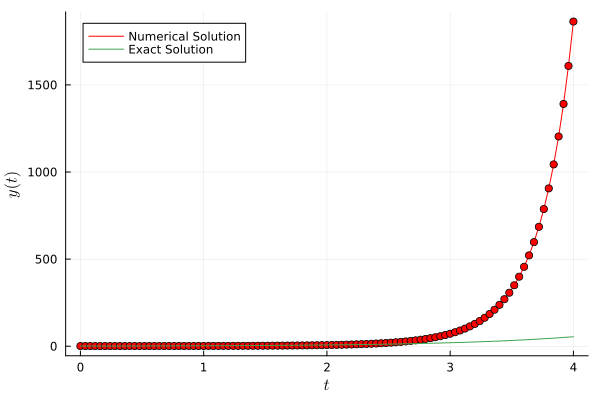

In [11]:
using Plots
gr()
plt = plot()
plot!(plt, t, y, color = :red, label = "Numerical Solution")
scatter!(plt, t, y, color = :red, label = "")
plot!(plt, t, y0 * exp.(λ * t), label = "Exact Solution")
plot!(plt, ylabel = "y", color = :blue, zlabel = "z")
plot!(ylabel = "\$y(t)\$", xlabel = "\$t\$")
plot!(plt, legend = :topleft)


**1a)** Try different values of `dt` and initial data. See what happens as `dt` increases or decreases. How does the system behave if $\lambda$ and $y_0$ are complex numbers?

*Hint: A complex number $c = a + bi$ is defined in Julia as `c = a + bim`. The functions `real(c)` and `imag(c)` return `a` and `b` respectively.*


**1b)** Use various values of N to compute the $Q$ factor of the Euler method.


**1c)**
Using $\lambda = 1, y_0 = 1$, implement the second- and fourth-order Runge-Kutta methods by creating two functions called `RK2step` and `RK4step`, similar to `EulerStep`. Plot again for different values of $N$ and compute the $Q$ factor for these methods.
 

**2) Stability of the solution**

Consider the equation
$$
\frac{dy}{dt} = y - y^2
$$

This equation has two stationary points: $y(t) = 1$ and $y(t) = 0$. Evolve the solution numerically with `y0 = 0:0.1:2` (that is, with initial data $y_0 = 0, y_0 = 0.1, ..., y_0 = 2$). Use the time interval $[0, 10]$. Plot using different methods and values of N and try to understand the behavior of the solution.

*Optional:* To observe the behavior for negative $y_0$, try `y0 = (0:-0.1:-0.5)` over the time interval $[0,1]$.


**3) Systems of equations**

The second-order ordinary differential equation
$$
\dfrac{d^{2}u(t)}{dt^2} = -\alpha^{2} u(t), \quad \alpha > 0
$$

has the general solution $u = A\cos(\alpha t) + B\sin(\alpha t)$.

To solve it numerically, we can convert it into a system of first-order ordinary differential equations by defining $v = \dfrac{du}{dt}$.

$$
    \begin{array}{c}
    \dfrac{du}{dt} &= &  v \\
    \dfrac{dv}{dt} &= &-\alpha^{2} u
    \end{array}
$$

**a)** Consider $$\alpha = 1, \quad u(0) = 1,\quad  v(0) = 0.$$  
Plot and compare the performance of the different methods with the exact solution.

*Hint: define `y0 = [u0, v0]`*